In [7]:
# imports
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_info_columns', 500)  # For .info() method
pd.set_option('display.max_info_rows', 500)     # For .info() method
pd.set_option('display.width', None)            # No line wrapping
pd.set_option('display.max_colwidth', None)     # Full column names

import re
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [8]:
# Load relevant data
weekly_player_offense = pd.read_csv('../data/nfl-stats-1999-2022/versions/17/weekly_player_stats_offense.csv')
weekly_player_offense = weekly_player_offense[weekly_player_offense['season'].isin([2022, 2023, 2024])]

yearly_player_offense = pd.read_csv('../data/nfl-stats-1999-2022/versions/17/yearly_player_stats_offense.csv')
yearly_player_offense = yearly_player_offense[yearly_player_offense['season'].isin([2022, 2023, 2024])]

# Filter to only fantasy-relevant positions
fantasy_positions = ['QB', 'RB', 'WR', 'TE', 'K']

# Filter player datasets to fantasy positions only
weekly_player_offense = weekly_player_offense[weekly_player_offense['position'].isin(fantasy_positions)]
yearly_player_offense = yearly_player_offense[yearly_player_offense['position'].isin(fantasy_positions)]

# **QB feature selection:**

In [9]:
# Filter to QB data only
qb_data = yearly_player_offense[yearly_player_offense['position'] == 'QB'].copy()

print(f"QB dataset shape: {qb_data.shape}")
print(f"QB seasons covered: {qb_data['season'].value_counts().sort_index()}")

# Identify QB-relevant columns (passing-focused)
qb_relevant_keywords = ['pass', 'completion', 'attempt', 'interception', 'sack', 'qb', 'fantasy', 'td', 'yard']
qb_columns = []

for col in qb_data.columns:
    if any(keyword in col.lower() for keyword in qb_relevant_keywords):
        qb_columns.append(col)

print(f"\nQB-relevant columns found: {len(qb_columns)}")
print("Sample QB columns:")
for col in qb_columns[:15]:  # Show first 15
    print(f"  {col}")
    
# Check target variable distribution for QBs
target = 'fantasy_points_ppr'
print(f"\nQB {target} statistics:")
print(qb_data[target].describe().round(2))

# Look for missing values in key columns
print(f"\nMissing values check:")
missing_counts = qb_data[qb_columns].isnull().sum()
missing_cols = missing_counts[missing_counts > 0]
if len(missing_cols) > 0:
    print(missing_cols)
else:
    print("No missing values in QB-relevant columns")

QB dataset shape: (252, 660)
QB seasons covered: season
2022    85
2023    83
2024    84
Name: count, dtype: int64

QB-relevant columns found: 297
Sample QB columns:
  qb_dropback
  qb_scramble
  pass_attempts
  complete_pass
  incomplete_pass
  passing_yards
  receiving_yards
  yards_after_catch
  rush_attempts
  rushing_yards
  first_down_pass
  pass_touchdown
  interception
  passing_air_yards
  receiving_air_yards

QB fantasy_points_ppr statistics:
count    252.00
mean     121.71
std      131.37
min       -3.08
25%       15.27
50%       65.65
75%      198.05
max      505.38
Name: fantasy_points_ppr, dtype: float64

Missing values check:
career_average_qb_dropback        29
career_average_qb_scramble        29
career_average_pass_attempts      29
career_average_complete_pass      29
career_average_incomplete_pass    29
                                  ..
delta_team_rush_attempts_share     4
delta_passer_rating                5
delta_pass_td_pct                  3
delta_rush_td_pct 

In [10]:
# Filter to QBs with meaningful playing time
# Let's see the distribution first
print("QB fantasy points distribution:")
print(qb_data['fantasy_points_ppr'].quantile([0.1, 0.25, 0.5, 0.75, 0.9]).round(2))

# Check games played if available
if 'games_played_season' in qb_data.columns:
    print(f"\nGames played distribution:")
    print(qb_data['games_played_season'].describe().round(2))
    
    # Filter to QBs who played significant games (e.g., 8+ games)
    qb_starters = qb_data[qb_data['games_played_season'] >= 8].copy()
    print(f"\nQBs with 8+ games: {len(qb_starters)} out of {len(qb_data)}")
else:
    # Alternative: filter by fantasy points threshold
    qb_starters = qb_data[qb_data['fantasy_points_ppr'] >= 50].copy()
    print(f"\nQBs with 50+ fantasy points: {len(qb_starters)} out of {len(qb_data)}")

# Now look at correlations for meaningful QB seasons
numeric_cols = qb_starters.select_dtypes(include=[np.number]).columns
qb_correlations = qb_starters[numeric_cols].corr()['fantasy_points_ppr'].abs().sort_values(ascending=False)
qb_correlations = qb_correlations.drop('fantasy_points_ppr', errors='ignore')

print(f"\nTop 15 QB features correlated with fantasy points:")
for feature, corr in qb_correlations.head(15).items():
    print(f"{feature:<50} {corr:.3f}")

QB fantasy points distribution:
0.10      1.32
0.25     15.27
0.50     65.65
0.75    198.05
0.90    331.07
Name: fantasy_points_ppr, dtype: float64

Games played distribution:
count    252.00
mean       7.85
std        5.73
min        1.00
25%        2.00
50%        6.00
75%       13.00
max       17.00
Name: games_played_season, dtype: float64

QBs with 8+ games: 112 out of 252

Top 15 QB features correlated with fantasy points:
fantasy_points_standard                            1.000
total_tds                                          0.982
season_fantasy_points_ppr                          0.976
season_fantasy_points_standard                     0.975
total_yards                                        0.948
pass_touchdown                                     0.939
season_pass_touchdown                              0.921
third_down_converted                               0.907
touches                                            0.901
passing_yards                                      0.9

In [11]:
# Proposed QB feature set to avoid multicollinearity
qb_features = {
    'volume_usage': 'touches',  # Represents overall involvement
    'passing_production': 'pass_touchdown',  # Passing efficiency vs raw yards
    'red_zone_efficiency': 'pass_touchdown_redzone',  # Goal-line value
    'consistency': 'third_down_converted',  # Clutch performance
    'historical_baseline': 'season_average_fantasy_points_ppr'  # Past performance
}

# Test this reduced feature set
selected_features = list(qb_features.values()) + ['fantasy_points_ppr']
qb_clean = qb_starters[selected_features].copy()

print("Correlation matrix with reduced feature set:")
print(qb_clean.corr().round(3))

Correlation matrix with reduced feature set:
                                   touches  pass_touchdown  \
touches                              1.000           0.852   
pass_touchdown                       0.852           1.000   
pass_touchdown_redzone               0.830           0.960   
third_down_converted                 0.941           0.866   
season_average_fantasy_points_ppr    0.744           0.846   
fantasy_points_ppr                   0.901           0.939   

                                   pass_touchdown_redzone  \
touches                                             0.830   
pass_touchdown                                      0.960   
pass_touchdown_redzone                              1.000   
third_down_converted                                0.841   
season_average_fantasy_points_ppr                   0.806   
fantasy_points_ppr                                  0.897   

                                   third_down_converted  \
touches                          

In [12]:
# More aggressive feature selection - pick one from each truly independent concept
final_qb_features = [
    'pass_touchdown',  # Choose this over pass_touchdown_redzone (simpler, broader metric)
    'season_average_fantasy_points_ppr',  # Historical performance (lowest correlation with others)
    # Remove touches and third_down_converted due to high correlation
]

# Test this minimal set
minimal_features = final_qb_features + ['fantasy_points_ppr']
qb_minimal = qb_starters[minimal_features].copy()

print("Minimal feature correlation matrix:")
print(qb_minimal.corr().round(3))

# Check if we can add one more feature without multicollinearity
print(f"\nCorrelations with remaining candidates:")
candidates = ['offense_snaps', 'rushing_yards', 'interception']
for candidate in candidates:
    if candidate in qb_starters.columns:
        corr_with_selected = qb_starters[final_qb_features + [candidate]].corr()
        max_corr = corr_with_selected.loc[candidate, final_qb_features].abs().max()
        print(f"{candidate:<20} max correlation: {max_corr:.3f}")

Minimal feature correlation matrix:
                                   pass_touchdown  \
pass_touchdown                              1.000   
season_average_fantasy_points_ppr           0.846   
fantasy_points_ppr                          0.939   

                                   season_average_fantasy_points_ppr  \
pass_touchdown                                                 0.846   
season_average_fantasy_points_ppr                              1.000   
fantasy_points_ppr                                             0.893   

                                   fantasy_points_ppr  
pass_touchdown                                  0.939  
season_average_fantasy_points_ppr               0.893  
fantasy_points_ppr                              1.000  

Correlations with remaining candidates:
offense_snaps        max correlation: 0.849
rushing_yards        max correlation: 0.517
interception         max correlation: 0.545


# **Creating ML Models**

=== QB MODEL TRAINING ===
Using features: ['pass_touchdown', 'season_average_fantasy_points_ppr', 'rushing_yards']
Target variable: fantasy_points_ppr
Training data shape: (112, 660)

Missing values in selected features:
pass_touchdown                       0
season_average_fantasy_points_ppr    0
rushing_yards                        0
fantasy_points_ppr                   0
dtype: int64

Data after removing missing values: (112, 4)

Feature statistics:
       pass_touchdown  season_average_fantasy_points_ppr  rushing_yards
count          112.00                             112.00         112.00
mean            18.02                              17.11         229.73
std             10.07                               5.48         227.53
min              1.00                               1.90          -1.00
25%             10.75                              13.46          70.00
50%             17.00                              17.23         155.00
75%             25.00                  

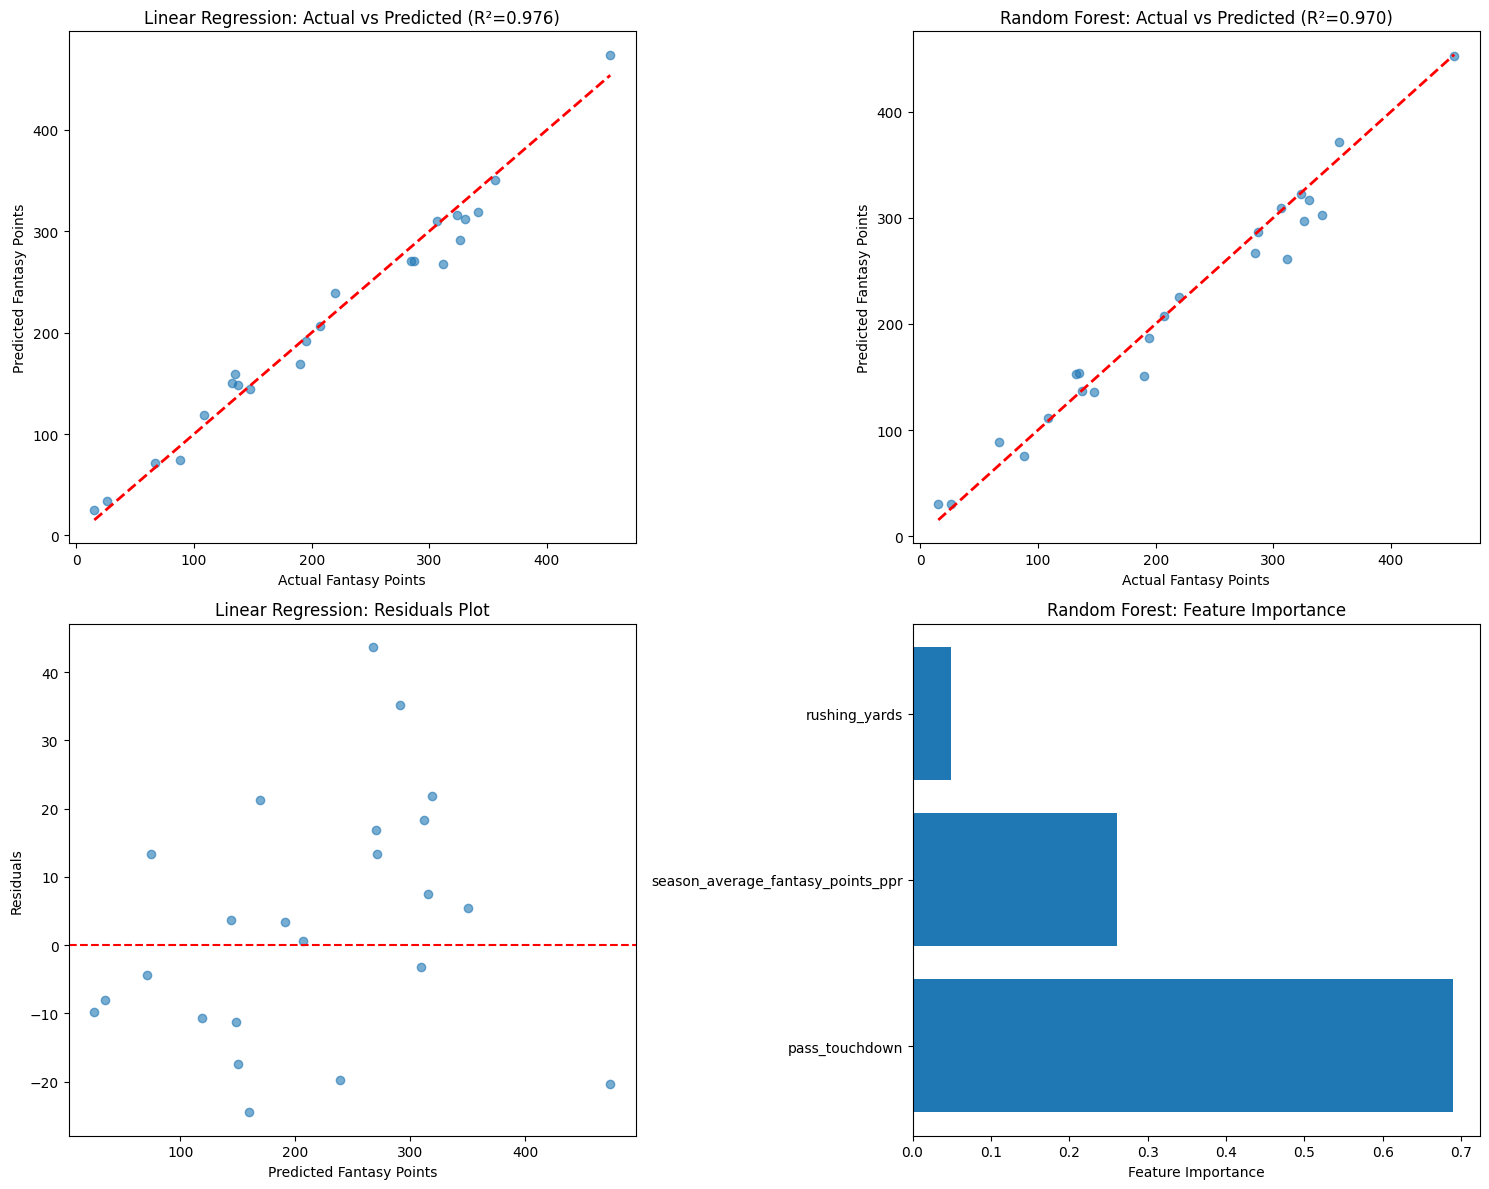


=== MODEL COMPARISON SUMMARY ===
               Model  R² Score    RMSE     MAE  CV R² Mean  CV R² Std
0  Linear Regression     0.976  17.815  14.515       0.951      0.012
1      Random Forest     0.970  19.917  14.494       0.920      0.029

Recommended model: Linear Regression

=== MODEL PACKAGE READY ===
Best model type: LinearRegression
Features: ['pass_touchdown', 'season_average_fantasy_points_ppr', 'rushing_yards']
Performance metrics: {'r2_score': 0.976271568625518, 'rmse': np.float64(17.815025117557287), 'mae': 14.515089868358196}

=== TESTING PREDICTION FUNCTION ===
Example prediction (25 TD, 200 avg PPR, 400 rush yards): 680.6 fantasy points

Sample predictions vs actual:
  Predicted: 74.7, Actual: 88.0, Diff: -13.4
  Predicted: 350.1, Actual: 355.6, Diff: -5.5
  Predicted: 206.6, Actual: 207.2, Diff: -0.7
  Predicted: 149.9, Actual: 132.6, Diff: +17.4
  Predicted: 270.8, Actual: 284.1, Diff: -13.4


In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Final QB features based on your analysis
final_qb_features = ['pass_touchdown', 'season_average_fantasy_points_ppr', 'rushing_yards']
target = 'fantasy_points_ppr'

print("=== QB MODEL TRAINING ===")
print(f"Using features: {final_qb_features}")
print(f"Target variable: {target}")
print(f"Training data shape: {qb_starters.shape}")

# Check for missing values in selected features
missing_check = qb_starters[final_qb_features + [target]].isnull().sum()
print(f"\nMissing values in selected features:")
print(missing_check)

# Handle missing values if any
qb_model_data = qb_starters[final_qb_features + [target]].copy()
qb_model_data = qb_model_data.dropna()
print(f"\nData after removing missing values: {qb_model_data.shape}")

# Prepare features and target
X = qb_model_data[final_qb_features]
y = qb_model_data[target]

print(f"\nFeature statistics:")
print(X.describe().round(2))
print(f"\nTarget statistics:")
print(y.describe().round(2))

# Train/test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=None
)

print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Scale features for Linear Regression (RandomForest doesn't need scaling)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train models
print("\n=== TRAINING MODELS ===")

# 1. Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# 2. Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)
rf_model.fit(X_train, y_train)

# Make predictions
lr_pred = lr_model.predict(X_test_scaled)
rf_pred = rf_model.predict(X_test)

# Evaluate models
def evaluate_model(y_true, y_pred, model_name):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    
    print(f"\n{model_name} Performance:")
    print(f"  R² Score: {r2:.3f}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  MAE: {mae:.2f}")
    return r2, rmse, mae

# Evaluate both models
lr_r2, lr_rmse, lr_mae = evaluate_model(y_test, lr_pred, "Linear Regression")
rf_r2, rf_rmse, rf_mae = evaluate_model(y_test, rf_pred, "Random Forest")

# Cross-validation for more robust evaluation
print("\n=== CROSS-VALIDATION RESULTS ===")
lr_cv_scores = cross_val_score(LinearRegression(), X_train_scaled, y_train, cv=5, scoring='r2')
rf_cv_scores = cross_val_score(RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10), 
                               X_train, y_train, cv=5, scoring='r2')

print(f"Linear Regression CV R²: {lr_cv_scores.mean():.3f} (+/- {lr_cv_scores.std() * 2:.3f})")
print(f"Random Forest CV R²: {rf_cv_scores.mean():.3f} (+/- {rf_cv_scores.std() * 2:.3f})")

# Feature importance/coefficients
print("\n=== FEATURE ANALYSIS ===")

# Linear Regression coefficients
print("Linear Regression Coefficients:")
for feature, coef in zip(final_qb_features, lr_model.coef_):
    print(f"  {feature}: {coef:.3f}")
print(f"  Intercept: {lr_model.intercept_:.3f}")

# Random Forest feature importance
print("\nRandom Forest Feature Importance:")
feature_importance = pd.DataFrame({
    'feature': final_qb_features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

for _, row in feature_importance.iterrows():
    print(f"  {row['feature']}: {row['importance']:.3f}")

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Actual vs Predicted for Linear Regression
axes[0,0].scatter(y_test, lr_pred, alpha=0.6)
axes[0,0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0,0].set_xlabel('Actual Fantasy Points')
axes[0,0].set_ylabel('Predicted Fantasy Points')
axes[0,0].set_title(f'Linear Regression: Actual vs Predicted (R²={lr_r2:.3f})')

# 2. Actual vs Predicted for Random Forest
axes[0,1].scatter(y_test, rf_pred, alpha=0.6)
axes[0,1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0,1].set_xlabel('Actual Fantasy Points')
axes[0,1].set_ylabel('Predicted Fantasy Points')
axes[0,1].set_title(f'Random Forest: Actual vs Predicted (R²={rf_r2:.3f})')

# 3. Residuals plot for Linear Regression
residuals_lr = y_test - lr_pred
axes[1,0].scatter(lr_pred, residuals_lr, alpha=0.6)
axes[1,0].axhline(y=0, color='r', linestyle='--')
axes[1,0].set_xlabel('Predicted Fantasy Points')
axes[1,0].set_ylabel('Residuals')
axes[1,0].set_title('Linear Regression: Residuals Plot')

# 4. Feature importance for Random Forest
axes[1,1].barh(feature_importance['feature'], feature_importance['importance'])
axes[1,1].set_xlabel('Feature Importance')
axes[1,1].set_title('Random Forest: Feature Importance')

plt.tight_layout()
plt.show()

# Model comparison summary
print("\n=== MODEL COMPARISON SUMMARY ===")
comparison = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest'],
    'R² Score': [lr_r2, rf_r2],
    'RMSE': [lr_rmse, rf_rmse],
    'MAE': [lr_mae, rf_mae],
    'CV R² Mean': [lr_cv_scores.mean(), rf_cv_scores.mean()],
    'CV R² Std': [lr_cv_scores.std(), rf_cv_scores.std()]
})
print(comparison.round(3))

# Recommendation for best model
best_model_idx = comparison['CV R² Mean'].idxmax()
best_model = comparison.loc[best_model_idx, 'Model']
print(f"\nRecommended model: {best_model}")

# Choose the better model based on CV scores
if rf_cv_scores.mean() > lr_cv_scores.mean():
    best_model_obj = rf_model
    best_scaler = None
    best_features = final_qb_features
    model_type = 'RandomForest'
else:
    best_model_obj = lr_model
    best_scaler = scaler
    best_features = final_qb_features
    model_type = 'LinearRegression'

# Create model dictionary
qb_model_package = {
    'model': best_model_obj,
    'scaler': best_scaler,
    'features': best_features,
    'model_type': model_type,
    'performance': {
        'r2_score': rf_r2 if model_type == 'RandomForest' else lr_r2,
        'rmse': rf_rmse if model_type == 'RandomForest' else lr_rmse,
        'mae': rf_mae if model_type == 'RandomForest' else lr_mae
    }
}

print(f"\n=== MODEL PACKAGE READY ===")
print(f"Best model type: {model_type}")
print(f"Features: {best_features}")
print(f"Performance metrics: {qb_model_package['performance']}")

# Example prediction function
def predict_qb_fantasy_points(pass_td, season_avg_ppr, rush_yards):
    """
    Predict QB fantasy points using the trained model
    
    Args:
        pass_td: Number of passing touchdowns
        season_avg_ppr: Season average PPR fantasy points
        rush_yards: Rushing yards
    
    Returns:
        Predicted fantasy points
    """
    input_data = np.array([[pass_td, season_avg_ppr, rush_yards]])
    
    if model_type == 'LinearRegression':
        input_scaled = best_scaler.transform(input_data)
        prediction = best_model_obj.predict(input_scaled)[0]
    else:
        prediction = best_model_obj.predict(input_data)[0]
    
    return max(0, prediction)  # Ensure non-negative prediction

# Test the prediction function
print("\n=== TESTING PREDICTION FUNCTION ===")
test_prediction = predict_qb_fantasy_points(25, 200, 400)
print(f"Example prediction (25 TD, 200 avg PPR, 400 rush yards): {test_prediction:.1f} fantasy points")

# Sample predictions on a few test examples
print(f"\nSample predictions vs actual:")
for i in range(min(5, len(X_test))):
    row = X_test.iloc[i]
    actual = y_test.iloc[i]
    
    if model_type == 'LinearRegression':
        pred = best_model_obj.predict(best_scaler.transform([row]))[0]
    else:
        pred = best_model_obj.predict([row])[0]
    
    print(f"  Predicted: {pred:.1f}, Actual: {actual:.1f}, Diff: {pred-actual:+.1f}")

In [15]:
import pickle
import joblib
import os
import json
from datetime import datetime

# Create models directory if it doesn't exist
models_dir = "../models"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)
    print(f"Created directory: {models_dir}")
else:
    print(f"Directory already exists: {models_dir}")

# Create QB-specific subdirectory
qb_model_dir = os.path.join(models_dir, "qb_model")
if not os.path.exists(qb_model_dir):
    os.makedirs(qb_model_dir)
    print(f"Created QB model directory: {qb_model_dir}")

# Save the complete model package using joblib (preferred for sklearn models)
model_file = os.path.join(qb_model_dir, "qb_model_package.joblib")
joblib.dump(qb_model_package, model_file)
print(f"Saved complete QB model package to: {model_file}")

# Also save individual components for flexibility
individual_files = {
    'model': os.path.join(qb_model_dir, "qb_model.joblib"),
    'scaler': os.path.join(qb_model_dir, "qb_scaler.joblib"),
}

# Save model
joblib.dump(qb_model_package['model'], individual_files['model'])
print(f"Saved QB model to: {individual_files['model']}")

# Save scaler
joblib.dump(qb_model_package['scaler'], individual_files['scaler'])
print(f"Saved QB scaler to: {individual_files['scaler']}")

# Create and save model metadata as JSON
model_metadata = {
    'model_type': qb_model_package['model_type'],
    'features': qb_model_package['features'],
    'performance': {
        'r2_score': float(qb_model_package['performance']['r2_score']),
        'rmse': float(qb_model_package['performance']['rmse']),
        'mae': float(qb_model_package['performance']['mae'])
    },
    'training_info': {
        'training_samples': len(X_train),
        'test_samples': len(X_test),
        'cv_r2_mean': float(lr_cv_scores.mean()),
        'cv_r2_std': float(lr_cv_scores.std()),
        'target_variable': target,
        'position': 'QB'
    },
    'feature_coefficients': {
        feature: float(coef) for feature, coef in zip(final_qb_features, lr_model.coef_)
    },
    'intercept': float(lr_model.intercept_),
    'created_date': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    'data_years': [2022, 2023, 2024]
}

metadata_file = os.path.join(qb_model_dir, "qb_model_metadata.json")
with open(metadata_file, 'w') as f:
    json.dump(model_metadata, f, indent=2)
print(f"Saved QB model metadata to: {metadata_file}")

# Create a README file for the model
readme_content = f"""# QB Fantasy Football Model

## Model Information
- **Model Type**: {model_metadata['model_type']}
- **Target Variable**: {model_metadata['training_info']['target_variable']}
- **Training Data**: {model_metadata['training_info']['training_samples']} samples
- **Test Data**: {model_metadata['training_info']['test_samples']} samples
- **Data Years**: {', '.join(map(str, model_metadata['data_years']))}

## Performance Metrics
- **R² Score**: {model_metadata['performance']['r2_score']:.3f}
- **RMSE**: {model_metadata['performance']['rmse']:.2f}
- **MAE**: {model_metadata['performance']['mae']:.2f}
- **Cross-Validation R²**: {model_metadata['training_info']['cv_r2_mean']:.3f} ± {model_metadata['training_info']['cv_r2_std']:.3f}

## Features Used
{chr(10).join(f"- {feature}" for feature in model_metadata['features'])}

## Model Coefficients
{chr(10).join(f"- {feature}: {coef:.3f}" for feature, coef in model_metadata['feature_coefficients'].items())}
- Intercept: {model_metadata['intercept']:.3f}

## Files in this Directory
- `qb_model_package.joblib`: Complete model package (recommended for loading)
- `qb_model.joblib`: Individual model object
- `qb_scaler.joblib`: Individual scaler object
- `qb_model_metadata.json`: Model metadata and performance metrics
- `README.md`: This documentation file

## Usage Example
```python
import joblib

# Load complete model package
qb_model_pkg = joblib.load('qb_model_package.joblib')

# Make prediction
def predict_qb_points(pass_td, season_avg_ppr, rush_yards):
    input_data = np.array([[pass_td, season_avg_ppr, rush_yards]])
    if qb_model_pkg['model_type'] == 'LinearRegression':
        input_scaled = qb_model_pkg['scaler'].transform(input_data)
        return qb_model_pkg['model'].predict(input_scaled)[0]
    else:
        return qb_model_pkg['model'].predict(input_data)[0]

# Example prediction
predicted_points = predict_qb_points(25, 20, 300)
```

## Model Created
{model_metadata['created_date']}
"""

readme_file = os.path.join(qb_model_dir, "README.md")
with open(readme_file, 'w') as f:
    f.write(readme_content)
print(f"Saved QB model README to: {readme_file}")

# Display directory structure
print(f"\n=== QB MODEL FILES SAVED ===")
print(f"Directory: {qb_model_dir}")
print("Files created:")
for file in os.listdir(qb_model_dir):
    file_path = os.path.join(qb_model_dir, file)
    size_kb = os.path.getsize(file_path) / 1024
    print(f"  - {file} ({size_kb:.1f} KB)")

# Test loading the model to verify it works
print(f"\n=== TESTING MODEL LOADING ===")
try:
    # Load the complete package
    loaded_model_pkg = joblib.load(model_file)
    
    # Test prediction function with loaded model
    def predict_with_loaded_model(pass_td, season_avg_ppr, rush_yards):
        input_data = np.array([[pass_td, season_avg_ppr, rush_yards]])
        if loaded_model_pkg['model_type'] == 'LinearRegression':
            input_scaled = loaded_model_pkg['scaler'].transform(input_data)
            return loaded_model_pkg['model'].predict(input_scaled)[0]
        else:
            return loaded_model_pkg['model'].predict(input_data)[0]
    
    # Test with the same example as before
    test_pred = predict_with_loaded_model(25, 200, 400)
    print(f"✓ Model loaded successfully!")
    print(f"✓ Test prediction with loaded model: {test_pred:.1f} fantasy points")
    print(f"✓ Original prediction was: {test_prediction:.1f} fantasy points")
    print(f"✓ Match: {'Yes' if abs(test_pred - test_prediction) < 0.01 else 'No'}")
    
except Exception as e:
    print(f"❌ Error loading model: {e}")

print(f"\n🎉 QB Model successfully saved and verified!")

Directory already exists: ../models
Saved complete QB model package to: ../models\qb_model\qb_model_package.joblib
Saved QB model to: ../models\qb_model\qb_model.joblib
Saved QB scaler to: ../models\qb_model\qb_scaler.joblib
Saved QB model metadata to: ../models\qb_model\qb_model_metadata.json
Saved QB model README to: ../models\qb_model\README.md

=== QB MODEL FILES SAVED ===
Directory: ../models\qb_model
Files created:
  - qb_model.joblib (0.6 KB)
  - qb_model_metadata.json (0.8 KB)
  - qb_model_package.joblib (1.5 KB)
  - qb_scaler.joblib (1.0 KB)
  - README.md (1.5 KB)

=== TESTING MODEL LOADING ===
✓ Model loaded successfully!
✓ Test prediction with loaded model: 680.6 fantasy points
✓ Original prediction was: 680.6 fantasy points
✓ Match: Yes

🎉 QB Model successfully saved and verified!
